# Refraction seismics - fitting a layered earth model
O. Kaufmann - Nov. 2017 - GPL v.3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.optimize import least_squares

In [2]:
class layered_earth_model(object):
    def __init__(self, v, z, theta, td):
        '''
        v : a list of compressive or shear waves velocities in the layers
        z : a list of the elevation of the top of the layers at x=0 
        theta : a list of dipping angles (in radians counterclockwise) of the top of the layers
        '''
        self.v = v
        self.z = z
        self.theta = theta
        self.td = td  # trigger delays
    
    @property
    def v(self):
        """Gets and sets the velocities in the model

        """
        return self.__v
    
    @v.setter
    def v(self, val):
        try:
            self.__v = list(val)
        except:
            print('could not set velocities')
            
    @property
    def z(self):
        """Gets and sets the elevations in the model

        """
        return self.__z
    
    @z.setter
    def z(self, val):
        try:
            self.__z = list(val)
        except:
            print('could not set elevations')
    
    @property
    def theta(self):
        """Gets and sets the dipping angles in the model

        """
        return self.__theta
    
    @theta.setter
    def theta(self, val):
        try:
            self.__theta = val
        except:
            print('could not set dipping angles')
    
    def layers_count(self):
        ''' Get the number of layers in the model
        
        :return: Number of layers in the model
        :rtype: float
        '''
        return len(self.v)
    
    def plot_model(self, x_span=(0., 1.), filled= True, *args, **kwargs):
        x_span.sort()
        z = [[self.z[i] + x_span[0] * np.tan(self.theta[i]), self.z[i] + x_span[1] * np.tan(self.theta[i])] 
             for i in range(self.layers_count())]
        for i in range(self.layers_count()):
            plt.plot(x_span, z[i], '-k', *args, **kwargs)
        if filled:
            for i in range(self.layers_count()-1):
                label = 'V%1d : %.0f m/s' %(i, self.v[i])
                plt.fill_between(x_span, z[i-1], z[i], label=label)
            label = 'V%1d : %.0f m/s' %(self.layers_count(), self.v[-1])
            plt.fill_between(x_span, z[-1], [1.2*min(z[-1]), 1.2*min(z[-1])], label=label)
            
    def plot_layout(self, sources, receivers):
        plt.plot(sources, np.zeros(len(sources)), '*r')
        plt.plot(receivers, np.zeros(len(receivers)), 'vk')
        
    def plot_response(self, sources, receivers, times, *args, **kwargs):
        plt.plot(sources, np.zeros(len(sources)), '*r')
        for i in range(len(sources)):
            plt.plot(receivers, times[i], '.k', *args, **kwargs)
            
    def two_layers_forward_refraction(self, sources, receivers):
        ic = np.arcsin(self.v[0]/self.v[1])
        x_span = [min(min(sources), min(receivers)), max(max(sources), max(receivers))]
        times = np.array([np.zeros(len(receivers)) for i in range(len(sources))])
        for j in range(len(sources)):
            h = (self.z[0]-self.z[1] - sources[j] * np.tan(self.theta[1]-self.theta[0])) * np.cos(self.theta[1]-self.theta[0]) # Thickness of layer one at the source point
            t_direct = [abs(receivers[i]-sources[j])/self.v[0] for i in range(len(receivers))]
            t_refracted = [(abs(receivers[i]-sources[j])/self.v[0])*np.sin(ic-np.sign(receivers[i]-sources[j])*(self.theta[1]-self.theta[0])) + (2 * h * np.cos(ic))/self.v[0] for i in range(len(receivers))]
            stacked = np.dstack((t_direct, t_refracted))
            times[j] = stacked.min(2).flatten() + self.td[j]
        return times

In [3]:
model_span = [-1., 50.]
sources = [0., 23.5, 49.]
receivers = np.arange(1., 49.)
v = [254., 1487]
z = [0, -3.7]
theta = [0.0, -0.05]
td = [0.003, -0.002, 0.001]

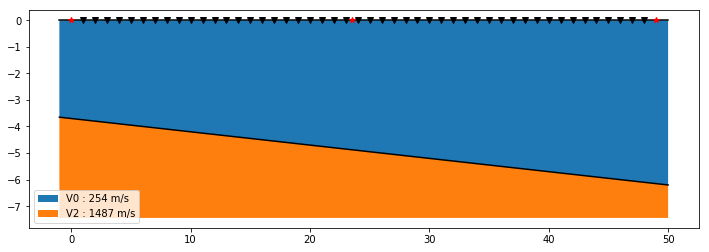

In [4]:
mod = layered_earth_model(v, z, theta, td)
plt.subplots(figsize = (12, 4))
mod.plot_model(model_span)
mod.plot_layout(sources, receivers)
plt.legend()

In [5]:
def model(params, config):
    v = params[0:2]
    z = [config[2], params[2]]
    theta = [config[3], params[3]]
    sources = config[0]
    td = params[4:len(sources)+4]
    receivers = config[1]
    ic = np.arcsin(v[0]/v[1])
    x_span = [min(min(sources), min(receivers)), max(max(sources), max(receivers))]
    times = np.array([np.zeros(len(receivers)) for i in range(len(sources))])
    for j in range(len(sources)):
        h = (z[0]-z[1] - sources[j] * np.tan(theta[1]-theta[0])) * np.cos(theta[1]-theta[0]) # Thickness of layer one at the source point
        t_direct = [abs(receivers[i]-sources[j])/v[0] for i in range(len(receivers))]
        t_refracted = [(abs(receivers[i]-sources[j])/v[0])*np.sin(ic-np.sign(receivers[i]-sources[j])*(theta[1]-theta[0])) + (2 * h * np.cos(ic))/v[0] for i in range(len(receivers))]
        stacked = np.dstack((t_direct, t_refracted))
        # print('j: %d, td[j]: %.3f' %(j, td[j]))
        times[j] = stacked.min(2).flatten() + td[j]
        # print(times[j])
    return times.flatten()

In [6]:
def fun(params, config, obs_times):
    return model(params, config) - obs_times

In [7]:
config = [sources, receivers, 0., 0.]  # x locations of sources, x locations of sources of receivers, ground elevation at x = 0, ground slope
starting_params = [750., 1800., -7., 0.09, 0., 0., 0.]
picking_noise = 0.003
theoretical_times = mod.two_layers_forward_refraction(sources, receivers)
if picked_times == '':
    obs_times = theoretical_times.flatten() - (0.5 * picking_noise * np.random.laplace(size=len(theoretical_times.flatten()))) + 0.5 * picking_noise * np.random.laplace(size=len(theoretical_times.flatten()))

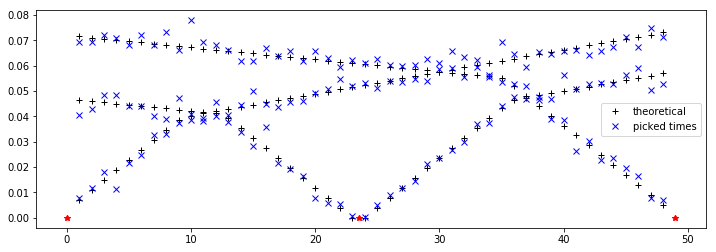

In [8]:
plt.subplots(figsize = (12, 4))
mod.plot_response(sources, receivers, theoretical_times, marker='+', label='theoretical')
mod.plot_response(sources, receivers, 
                  [[obs_times[i] for i in range(len(receivers)*j, len(receivers)*(j+1))] for j in range(len(sources))],
                  marker='x', color='blue', label='picked times')
# plot legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [9]:
starting_times = model(starting_params, config)
starting_times = [[starting_times[i] for i in range(len(receivers)*j, len(receivers)*(j+1))] for j in range(len(sources))]

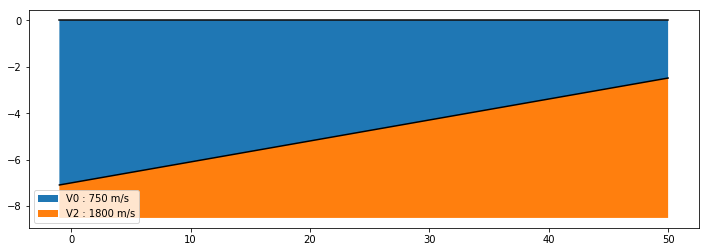

In [10]:
starting_model=layered_earth_model(v=starting_params[0:2], z=[0., starting_params[2]], theta=[0., starting_params[3]], td=td)
plt.figure(figsize=(12,4))
starting_model.plot_model(model_span)
plt.legend()

In [11]:
res = least_squares(fun, starting_params, bounds=([150., 400., -10., -0.1, -0.005, -0.005, -0.005], [1000., 2500., -1., 0.1, 0.005, 0.005, 0.005]),
                    args=(config, obs_times), verbose=1, loss='soft_l1')
[v1, v2, z0, theta, td[0], td[1], td[2]] = [mod.v[0], mod.v[1], mod.z[1], mod.theta[1], mod.td[0], mod.td[1], mod.td[2]]
print('Theoretical model:\nV1: %.0f m/s, V2: %.0f m/s, z(0): %.1f m, dip: %.0f°, td: %.3f , %.3f , %.3f' %(v1, v2, z0, theta*180/np.pi, mod.td[0], mod.td[1], mod.td[2]))
[v1, v2, z0, theta, td[0], td[1], td[2]] = res.x
print('Fitted model:\nV1: %.0f m/s, V2: %.0f m/s, z(0): %.1f m, dip: %.0f°, td: %.3f , %.3f , %.3f' %(v1, v2, z0, theta*180/np.pi, td[0], td[1], td[2]))

`gtol` termination condition is satisfied.
Function evaluations 10, initial cost 5.7560e-02, final cost 6.0193e-04, first-order optimality 6.16e-10.
Theoretical model:
V1: 254 m/s, V2: 1487 m/s, z(0): -3.7 m, dip: -3°, td: 0.003 , -0.002 , 0.001
Fitted model:
V1: 263 m/s, V2: 1532 m/s, z(0): -3.8 m, dip: -3°, td: 0.004 , -0.001 , 0.002


In [12]:
calc_times = model(res.x, config)
calc_times = [[calc_times[i] for i in range(len(receivers)*j, len(receivers)*(j+1))] for j in range(len(sources))]
obs_times = [[obs_times[i] for i in range(len(receivers)*j, len(receivers)*(j+1))] for j in range(len(sources))]

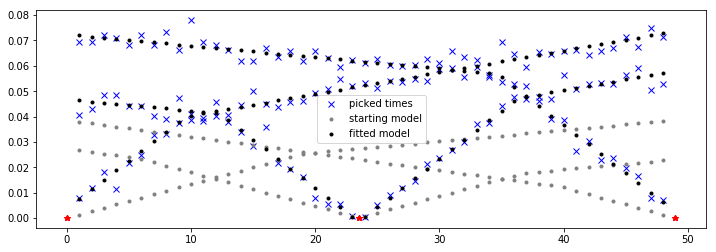

In [13]:
times = mod.two_layers_forward_refraction(sources, receivers)
plt.subplots(figsize = (12, 4))
mod.plot_response(sources, receivers, obs_times, marker='x', color='blue', label='picked times')
mod.plot_response(sources, receivers, starting_times, marker= '.', color= 'grey', label='starting model')
mod.plot_response(sources, receivers, calc_times, marker= '.', color= 'black', label='fitted model')
# plot legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

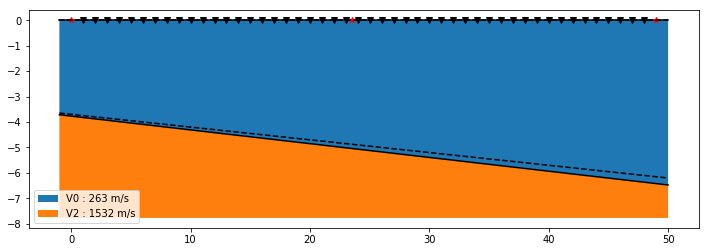

In [14]:
optimized_model = layered_earth_model(v=res.x[0:2], z=[0., res.x[2]], theta=[0., res.x[3]], td= [res.x[4], res.x[5], res.x[6]])
plt.figure(figsize=(12,4))
optimized_model.plot_model(model_span)
optimized_model.plot_layout(sources, receivers)
mod.plot_model(model_span, filled=False, linestyle='--')
plt.legend()